In [1]:
import ast
import datetime
import torch
import lightning as pl
import pandas as pd
from lightning.pytorch.callbacks import LearningRateMonitor, ModelCheckpoint
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.loggers import WandbLogger
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import segmentation_models_pytorch as smp
import os
import sys
sys.path.append(os.path.join(os.path.dirname('__file__'), '..'))
from src.data.data import HuBMapDataModule
from src.model.model import Model,Segformer

/home/tamukake/Github/HuBMAP/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
architecture = "unet"
num_workers = 10
batch_size = 32
height = 768
width = 768
img_dir = "./data/"
target_name = "blood_vessel"
row_name = "id"
gray_scale = False
pretrained = "imagenet"
backbone = "timm-efficientnet-b0"
activation = None
in_channels = 3
epochs = 50
warm_up_epohs = 10
classes = 1
threshold = 0.5
model_mode = "binary"
precision = "16-mixed"  # default 32-true
accumulate_grad_batches = 1
cutmix_args = {
    "prob": 0.50,
    "enable": True,
    "alpha": 0.5,
    "height": height,
    "width": width,
}
tile_meta = pd.read_csv("../data/tile_meta.csv")
df = tile_meta[tile_meta["dataset"] == 3].reset_index(drop=True)
# train_df, valid_df = train_test_split(df)
# train_df = train_df.reset_index(drop=True)
# valid_df = valid_df.reset_index(drop=True)
print(df.head())

             id  source_wsi  dataset      i      j
0  000e79e206b7           6        3  10240  29184
1  00176a88fdb0           7        3  14848  25088
2  00359ab8338b           8        3   6656   9216
3  00488ca285ee           9        3   8192  37888
4  004fb033dd09           7        3  20480  31232


In [3]:
device =  torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
if architecture != "unet":
    print("Segformer")
    model = Segformer(
            backbone=backbone,
            gray_scale=gray_scale,
            pretrained=pretrained,
            in_channels=in_channels,
            warm_up_epochs=warm_up_epohs,
            epochs=epochs,
            classes=classes,
            mode=model_mode,
            activation=activation,
        )
else:
    print("unet")
    model = Model(backbone=backbone,
        gray_scale=gray_scale,
        pretrained=pretrained,
        in_channels=in_channels,
        warm_up_epochs=warm_up_epohs,
        epochs=epochs,
        classes=classes,
        mode=model_mode,
        activation=activation,
        threshold=threshold,)

unet


In [4]:
modelWeight= "../outputs/UNET/timm-efficientnet-b0/20230624150207/last.ckpt"
model.load_state_dict(torch.load(modelWeight)['state_dict'])
model.to(device)

Model(
  (model): UnetPlusPlus(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): Swish()
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNormAct2d(
              32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): Swish()
            )
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()
            )
            (

In [5]:
import os
import cv2
import albumentations as A 
from albumentations.pytorch.transforms import ToTensorV2
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms.functional import rgb_to_grayscale
height = 768
width = 768
mean = [0.62405882, 0.40748174, 0.68217106]
std = [0.15112928, 0.20741797, 0.13163469]
valid_transform = A.Compose([
    A.Resize(height, width, always_apply=True, p=1),
    # A.Normalize(mean=mean, std=std, p=1),
    ToTensorV2(transpose_mask=True),
])
class DatasetTest(Dataset):
    def __init__(self, df,transforms):
        self.df = df 
        self.unique_id = list(df["id"].unique())
        self.transforms = transforms 
    def __getitem__(self, idx):
        target_id = self.unique_id[idx]
        # df[df["id"] == "0006ff2aa7cd"]
        img_path = os.path.join("../data/", "train_images_dataset3", target_id + ".png")
        im = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
        #mask = np.argmax(mask,axis=-1)
        if self.transforms is not None: 
            transformed = self.transforms(image = im)
            return transformed['image']/255,target_id
    def __len__(self):
        return len(self.unique_id)

In [6]:
from glob import glob
dataset = DatasetTest(df,valid_transform)
test_loader = DataLoader(dataset, batch_size=1, shuffle=False)
print(len(dataset))

5400


In [7]:
def masks2segments(masks, strategy='largest'):
    # Convert masks(n,160,160) into segments(n,xy)
    segments = []
    for x in masks.int().cpu().numpy().astype('uint8'):
        print(x.shape)
        c = cv2.findContours(x, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]
        if strategy == 'concat':  # concatenate all segments
            c = np.concatenate([x.reshape(-1, 2) for x in c])
        elif strategy == 'largest':  # select largest segment
            c = np.array(c[np.array([len(x) for x in c]).argmax()]).reshape(-1, 2)
        segments.append(c.astype('float32'))
    return segments

  0%|▎                                                                                                                                                                               | 9/5400 [00:00<02:17, 39.09it/s]


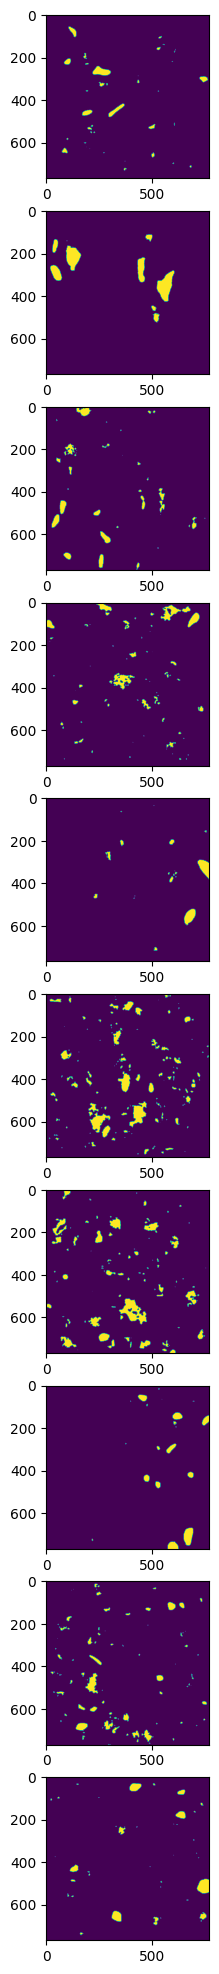

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
fig, ax = plt.subplots(10, 1,figsize=(25,25))
with torch.no_grad():
    for  idx,(images,target_id) in enumerate(tqdm(test_loader)):
        b,c,h,w = images.shape
        if architecture != "unet":
            outputs = model(images.to(device),None)
            upsampled_logits = nn.functional.interpolate(
                outputs.logits, size=images.shape[-2:], mode="bilinear", align_corners=False
            )
        else:
            outputs = model(images.to(device).float())
            upsampled_logits = outputs
        upsampled_logits[upsampled_logits > 0.99] = 255
        upsampled_logits[upsampled_logits < 0.99] = 0 
        ax[idx].imshow(upsampled_logits.cpu().detach().reshape(h,w,1))
        if idx == 9:
            break

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torchvision.transforms.functional as F
ids = []
type = []
cords = []
os.makedirs('../data/mask_images_dataset3', exist_ok=True)

with torch.no_grad():
    for  idx,(images,target_id) in enumerate(tqdm(test_loader)):
        outputs = F.resize(img=model(images.to(device).float()), size=(512, 512))
        b,c,h,w = outputs.shape
        upsampled_logits = outputs
        upsampled_logits[upsampled_logits > 0.99] = 255
        upsampled_logits[upsampled_logits < 0.99] = 0 
        mask = upsampled_logits.cpu().detach().numpy().reshape(h,w,1)
        if np.max(mask) == 255:
            ids.append(target_id[0])
            type.append("blood_vessel")
            cv2.imwrite(f'../data/mask_images_dataset3/{target_id[0]}.png', mask)

  0%|                                                                                                                                                                                        | 0/5400 [00:00<?, ?it/s]/home/tamukake/Github/HuBMAP/.venv/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████████████████████████████████████

In [13]:
import os
path = "../data/mask_images_dataset3"
files = os.listdir(path)
mask_file = [f for f in files if os.path.isfile(os.path.join(path, f))]

In [14]:
import os
path = "../data/train_images_dataset3"
files = os.listdir(path)
img_file = [f for f in files if os.path.isfile(os.path.join(path, f))]

In [15]:
set(mask_file) == set(img_file)

True

In [16]:
new_df = pd.DataFrame()
new_df["id"] = ids
new_df["type"] = type
new_df["dataset3"] = [True for i in range(len(ids))]

In [17]:
# new_df.to_csv("../data/dataset3_2stage.csv",index=False)

In [18]:
df = pd.read_csv("../data/labels_1class.csv")
new_df = pd.read_csv("../data/dataset3_2stage.csv")

In [19]:
print(df.columns)
print(new_df.columns)

Index(['id', 'type', 'coordinates', 'mask', 'rle'], dtype='object')
Index(['id', 'type', 'dataset3'], dtype='object')


In [20]:
pd.merge(df,new_df,how = "outer")

,id,type,coordinates,mask,rle,dataset3
0,0006ff2aa7cd,blood_vessel,"[[[283, 109], [282, 109], [281, 109], [280, 10...",[[0 0 0 ... 0 0 0]\n [0 0 0 ... 0 0 0]\n [0 0 ...,['208982 10 209748 17 210514 22 211280 27 2120...,NaN
1,0006ff2aa7cd,blood_vessel,"[[[104, 292], [103, 292], [102, 292], [101, 29...",[[0 0 0 ... 0 0 0]\n [0 0 0 ... 0 0 0]\n [0 0 ...,['55540 4 56306 8 57073 11 57840 14 58608 15 5...,NaN
2,0006ff2aa7cd,blood_vessel,"[[[505, 442], [504, 442], [503, 442], [502, 44...",[[0 0 0 ... 0 0 0]\n [0 0 0 ... 0 0 0]\n [0 0 ...,['375967 11 376732 20 377497 26 378263 30 3790...,NaN
3,0006ff2aa7cd,blood_vessel,"[[[375, 477], [374, 477], [373, 477], [372, 47...",[[0 0 0 ... 0 0 0]\n [0 0 0 ... 0 0 0]\n [0 0 ...,['250808 5 251575 7 252342 10 253110 11 253878...,NaN
4,0006ff2aa7cd,blood_vessel,"[[[368, 410], [367, 410], [366, 410], [365, 41...",[[0 0 0 ... 0 0 0]\n [0 0 0 ... 0 0 0]\n [0 0 ...,['257640 10 258405 18 259171 24 259938 28 2607...,NaN
...,...,...,...,...,...,...
21449,ffb1ccab4d28,blood_vessel,NaN,NaN,NaN,True
21450,ffd37b5c6598,blood_vessel,NaN,NaN,NaN,True
21451,ffd77e2517af,blood_vessel,NaN,NaN,NaN,True
21452,ffe3cbb81f72,blood_vessel,NaN,NaN,NaN,True


In [24]:
import os
path = "../data/mask_images_dataset123_class1"
files = os.listdir(path)
mask_file = [f for f in files if os.path.isfile(os.path.join(path, f))]

In [25]:
import os
path = "../data/train_images_dataset123_class1"
files = os.listdir(path)
img_file = [f for f in files if os.path.isfile(os.path.join(path, f))]

In [27]:
print(set(img_file) == set(mask_file))
print(len(set(img_file)))
print(len(set(mask_file)))

True
7022
7022
